# Multiple Linear Regression สำหรับทำนายราคาน้ำมัน Brent

คู่ทำ MLR คือ
1. พู่กัน
2. เจฟ

## 1. Import Libraries

In [1]:
from lib_import import *
from sklearn.linear_model import LinearRegression
import joblib

lib_import.py imported successfully


## 2. Load and Explore

In [2]:
df = pd.read_csv('../data/processed/merged_oil_prices.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
df.head()

,date,open_x,high_x,low_x,close_x,volume_x,average_x,open_y,high_y,low_y,close_y,volume_y,average_y
0,2017-11-02,56.73,56.73,56.73,56.73,0,56.73,51.32,51.32,51.32,51.32,0,51.32
1,2017-11-03,56.84,56.84,56.84,56.84,0,56.84,51.39,51.39,51.39,51.39,0,51.39
2,2017-11-06,57.26,57.26,57.26,57.26,0,57.26,51.07,51.07,51.07,51.07,0,51.07
3,2017-11-07,57.40,57.40,57.40,57.40,0,57.40,51.43,51.43,51.43,51.43,0,51.43
4,2017-11-08,58.17,58.17,58.17,58.17,0,58.17,52.22,52.22,52.22,52.22,0,52.22


In [3]:
df.describe()

,date,open_x,high_x,low_x,close_x,volume_x,average_x,open_y,high_y,low_y,close_y,volume_y,average_y
count,1846,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000
mean,2021-07-17 19:40:14.301191680,65.546100,65.597969,65.481219,65.537378,74.929577,65.539395,60.055937,60.190195,59.891966,60.033364,890.858072,60.043776
min,2017-11-02 00:00:00,46.440000,46.440000,46.440000,46.440000,0.000000,46.440000,40.390000,40.390000,40.390000,40.390000,0.000000,40.390000
25%,2019-09-13 18:00:00,57.990000,57.990000,57.990000,57.990000,0.000000,57.990000,52.052500,52.052500,52.052500,52.052500,0.000000,52.052500
50%,2021-07-12 12:00:00,63.440000,63.440000,63.440000,63.440000,0.000000,63.440000,55.770000,55.770000,55.770000,55.770000,0.000000,55.770000
75%,2023-05-29 00:00:00,74.800000,74.975000,74.587500,74.767500,0.000000,74.796500,69.877500,70.220000,69.577500,69.877500,98.000000,69.944000
max,2025-04-03 00:00:00,83.930000,83.930000,83.930000,83.930000,11399.000000,83.930000,79.010000,79.140000,79.010000,79.010000,35933.000000,79.010000
std,NaN,9.821117,9.866789,9.767207,9.814503,572.919216,9.815091,10.131954,10.268160,9.966742,10.108302,2817.752398,10.120639


In [4]:
print('Missing')
print(df.isnull().sum())

Missing
date         0
open_x       0
high_x       0
low_x        0
close_x      0
volume_x     0
average_x    0
open_y       0
high_y       0
low_y        0
close_y      0
volume_y     0
average_y    0
dtype: int64


## 3. Feature Engineering

In [5]:
data = df.copy()

# Brent (close_x) เพื่อเก็บราคา 1 3 5 7 วันก่อน
for lag in [1, 3, 5, 7]:
    data[f'brent_lag_{lag}'] = data['close_x'].shift(lag)

# WTI (close_y) เพื่อเก็บราคา 1 3 5 7 วันก่อน
for lag in [1, 3, 5, 7]:
    data[f'wti_lag_{lag}'] = data['close_y'].shift(lag)

# moving average ของ brent และ WTI เพื่อหาแนวโน้มโดยเฉลี่ย 5 และ 10 วันย้อนหลัง
data['brent_ma_5'] = data['close_x'].rolling(window=5).mean()
data['brent_ma_10'] = data['close_x'].rolling(window=10).mean()
data['wti_ma_5'] = data['close_y'].rolling(window=5).mean()
data['wti_ma_10'] = data['close_y'].rolling(window=10).mean()
data['target'] = data['close_x'].shift(-1)
data_clean = data.dropna().reset_index(drop=True)

print(f'จำนวนข้อมูลหลังสร้าง features: {len(data_clean)} แถว')
print(f'จำนวน features: {len(data_clean.columns) - 2} คอลัมน์ (ไม่นับ date และ target)')
print('\nFeatures ที่สร้างขึ้น:')
feature_cols = [col for col in data_clean.columns if col not in df.columns and col != 'target']
print(feature_cols)

print(data_clean)

จำนวนข้อมูลหลังสร้าง features: 1836 แถว
จำนวน features: 24 คอลัมน์ (ไม่นับ date และ target)

Features ที่สร้างขึ้น:
['brent_lag_1', 'brent_lag_3', 'brent_lag_5', 'brent_lag_7', 'wti_lag_1', 'wti_lag_3', 'wti_lag_5', 'wti_lag_7', 'brent_ma_5', 'brent_ma_10', 'wti_ma_5', 'wti_ma_10']
           date  open_x  high_x  low_x  close_x  volume_x  average_x  open_y  \
0    2017-11-15   58.00   58.00  58.00    58.00         0     58.000   52.23   
1    2017-11-16   57.16   57.16  57.16    57.16         0     57.160   51.14   
2    2017-11-17   57.06   57.06  57.06    57.06         0     57.060   50.88   
3    2017-11-20   56.58   56.58  56.58    56.58         0     56.580   50.60   
4    2017-11-21   56.38   56.38  56.38    56.38         0     56.380   50.28   
...         ...     ...     ...    ...      ...       ...        ...     ...   
1831 2025-03-27   72.94   73.36  72.52    73.35      5545     73.083   69.15   
1832 2025-03-28   73.15   73.16  72.28    72.41      6362     72.694   69.35 

## 4. Prepare information for Training

In [6]:
feature_columns = [
    # Brent features
    'close_x', 'open_x', 'high_x', 'low_x', 'average_x',
    'brent_lag_1', 'brent_lag_3', 'brent_lag_5', 'brent_lag_7',
    'brent_ma_5', 'brent_ma_10',
    # WTI features
    'close_y', 'open_y', 'high_y', 'low_y', 'average_y',
    'wti_lag_1', 'wti_lag_3', 'wti_lag_5', 'wti_lag_7',
    'wti_ma_5', 'wti_ma_10'
]

X = data_clean[feature_columns]
y = data_clean['target']

print(f'Shape ของ X: {X.shape}')
print(f'Shape ของ y: {y.shape}')
print(f'\nจำนวน features ทั้งหมด: {X.shape[1]}')

Shape ของ X: (1836, 22)
Shape ของ y: (1836,)

จำนวน features ทั้งหมด: 22


In [7]:
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

dates_train = data_clean['date'][:train_size]
dates_val = data_clean['date'][train_size:train_size+val_size]
dates_test = data_clean['date'][train_size+val_size:]

print('การแบ่งข้อมูล:')
print(f'Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)')
print(f'Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)')
print(f'Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)')

การแบ่งข้อมูล:
Training set: 1285 samples (70.0%)
Validation set: 275 samples (15.0%)
Test set: 276 samples (15.0%)


In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
print(f'Mean ของ training features หลัง scaling: {X_train_scaled.mean():.6f}')
print(f'Std ของ training features หลัง scaling: {X_train_scaled.std():.6f}')

Mean ของ training features หลัง scaling: -0.000000
Std ของ training features หลัง scaling: 1.000000


## 5. Build and Train Multiple Linear Regression Model

ใช้ Multiple Linear Regression จาก scikit-learn:
- สมการ: $\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n$
- ใช้วิธี Ordinary Least Squares (OLS) ในการหาค่า coefficients
- ไม่ต้อง tune hyperparameters เพราะ Linear Regression ไม่มี hyperparameters ที่ต้องปรับ

In [9]:
model = LinearRegression(
    fit_intercept=True,
    n_jobs=-1
)

print('Model: Multiple Linear Regression')
print(f'Input features: {X_train_scaled.shape[1]}')
print(f'Fit intercept: {model.fit_intercept}')

Model: Multiple Linear Regression
Input features: 22
Fit intercept: True


In [10]:
# Train model
print('=' * 50)

model.fit(X_train_scaled, y_train)

print('✓ Training เสร็จสิ้น!')
print(f'\nIntercept (β₀): {model.intercept_:.4f}')
print(f'\nCoefficients (β₁ ถึง β{len(feature_columns)}):')
for name, coef in zip(feature_columns, model.coef_):
    print(f'  {name:20s}: {coef:10.4f}')

✓ Training เสร็จสิ้น!

Intercept (β₀): 61.5128

Coefficients (β₁ ถึง β22):
  close_x             :     1.5280
  open_x              :     1.5280
  high_x              :     1.5280
  low_x               :     1.5280
  average_x           :     1.5280
  brent_lag_1         :     0.5057
  brent_lag_3         :    -1.9860
  brent_lag_5         :     1.9420
  brent_lag_7         :     4.4641
  brent_ma_5          :     6.5857
  brent_ma_10         :   -10.4935
  close_y             :   -18.4942
  open_y              :   -14.8585
  high_y              :    16.7619
  low_y               :    18.4497
  average_y           :    -1.3701
  wti_lag_1           :    -0.0320
  wti_lag_3           :     1.9615
  wti_lag_5           :    -0.9553
  wti_lag_7           :    -3.8484
  wti_ma_5            :    -6.4744
  wti_ma_10           :     9.0192


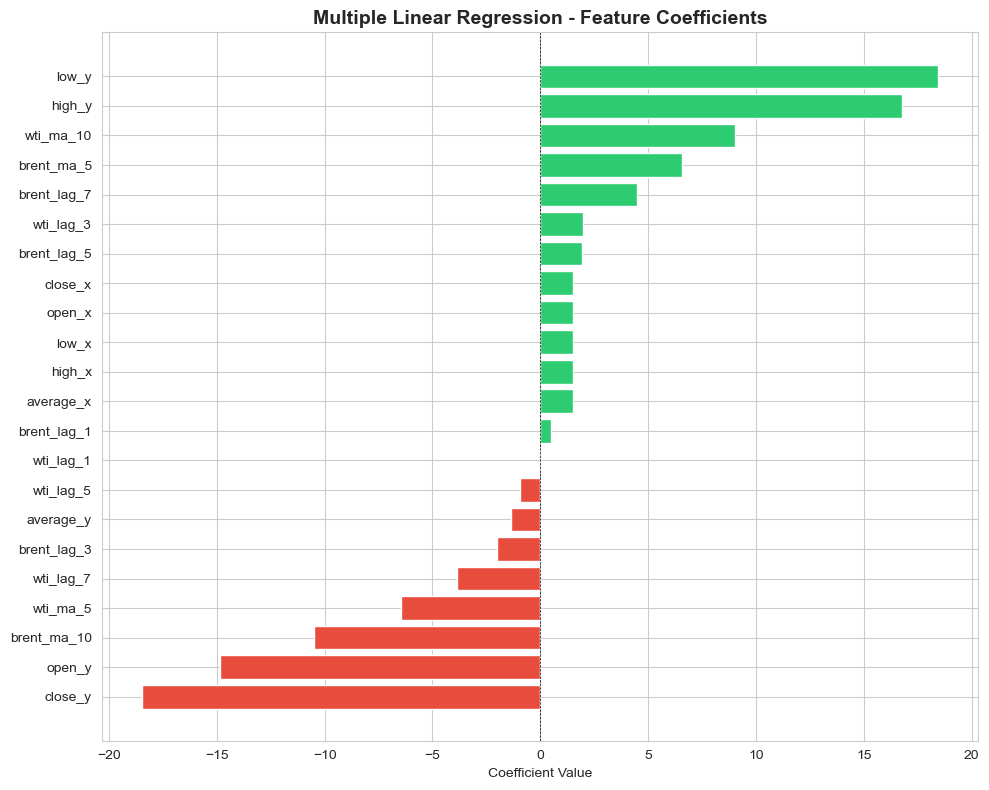


Features ที่มีอิทธิพลสูงสุด (ตามค่าสัมบูรณ์):
  close_y             :   -18.4942 (↓ ลบ)
  low_y               :    18.4497 (↑ บวก)
  high_y              :    16.7619 (↑ บวก)
  open_y              :   -14.8585 (↓ ลบ)
  brent_ma_10         :   -10.4935 (↓ ลบ)


In [11]:
# แสดง Coefficients ในรูปแบบกราฟ
coef_df = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': model.coef_
})
coef_df = coef_df.sort_values('Coefficient', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#e74c3c' if c < 0 else '#2ecc71' for c in coef_df['Coefficient']]
ax.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors)
ax.set_xlabel('Coefficient Value')
ax.set_title('Multiple Linear Regression - Feature Coefficients', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.5, linestyle='--')
plt.tight_layout()
plt.show()

print('\nFeatures ที่มีอิทธิพลสูงสุด (ตามค่าสัมบูรณ์):')
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
top_features = coef_df.sort_values('Abs_Coefficient', ascending=False).head(5)
for _, row in top_features.iterrows():
    direction = '↑ บวก' if row['Coefficient'] > 0 else '↓ ลบ'
    print(f"  {row['Feature']:20s}: {row['Coefficient']:10.4f} ({direction})")

## 6. Evaluate result

In [12]:
# Prediction
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

def calculate_metrics(y_true, y_pred, set_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f'\n {set_name}:')
    print(f'   MSE  = {mse:.4f}')
    print(f'   RMSE = {rmse:.4f}')
    print(f'   MAE  = {mae:.4f}')
    print(f'   R²   = {r2:.4f}')
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

print('=' * 50)
print('MODEL PERFORMANCE')
print('=' * 50)

train_metrics = calculate_metrics(y_train, y_train_pred, 'Training Set')
val_metrics = calculate_metrics(y_val, y_val_pred, 'Validation Set')
test_metrics = calculate_metrics(y_test, y_test_pred, 'Test Set')

results_df = pd.DataFrame({
    'Training': train_metrics,
    'Validation': val_metrics,
    'Test': test_metrics
})

print('\nSummary Table:')
print(results_df)

MODEL PERFORMANCE

 Training Set:
   MSE  = 0.5460
   RMSE = 0.7389
   MAE  = 0.5303
   R²   = 0.9930

 Validation Set:
   MSE  = 1.2969
   RMSE = 1.1388
   MAE  = 0.8952
   R²   = 0.8799

 Test Set:
   MSE  = 1.4529
   RMSE = 1.2054
   MAE  = 0.9299
   R²   = 0.8701

Summary Table:
      Training  Validation      Test
MSE   0.546018    1.296925  1.452916
RMSE  0.738930    1.138826  1.205370
MAE   0.530263    0.895152  0.929891
R2    0.993001    0.879935  0.870064


## 7. Visualization

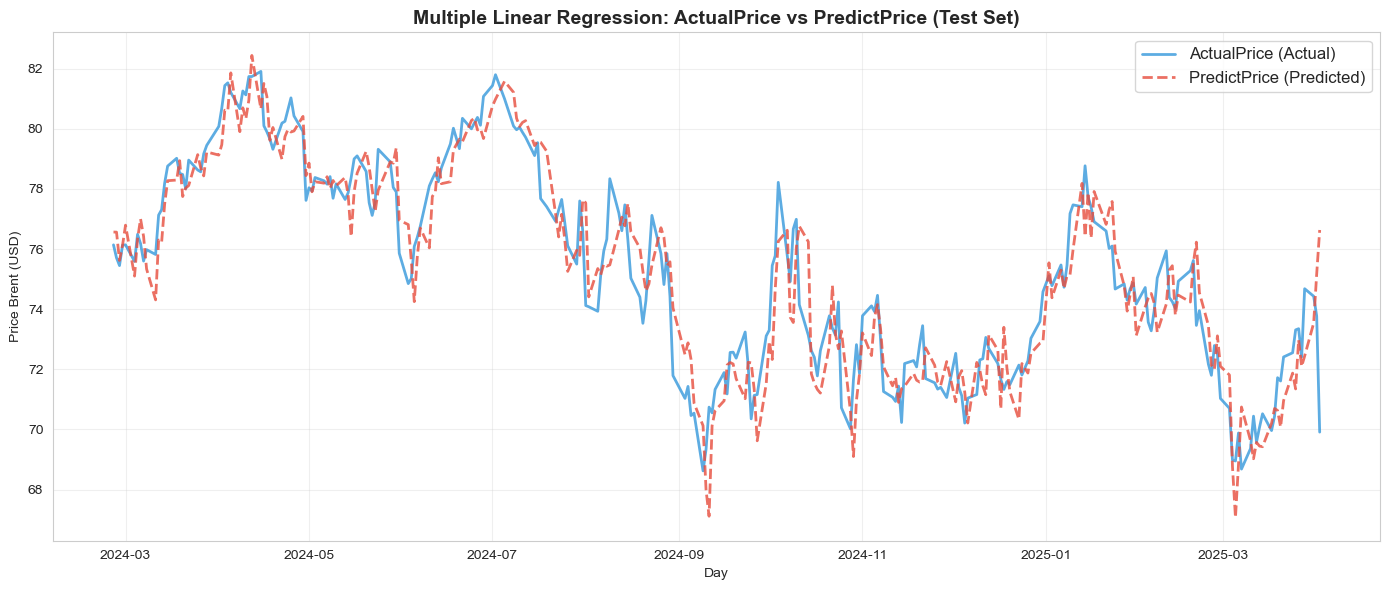

In [13]:
# กราฟเปรียบเทียบราคาจริง vs ราคาที่ทำนาย (Test Set)
plt.figure(figsize=(14, 6))

plt.plot(dates_test.values, y_test.values, 
         label='ActualPrice (Actual)',
         color='#3498db', linewidth=2, alpha=0.8)

plt.plot(dates_test.values, y_test_pred, 
         label='PredictPrice (Predicted)',
         color='#e74c3c', linewidth=2, alpha=0.8, linestyle='--')

plt.title('Multiple Linear Regression: ActualPrice vs PredictPrice (Test Set)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Day')
plt.ylabel('Price Brent (USD)')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

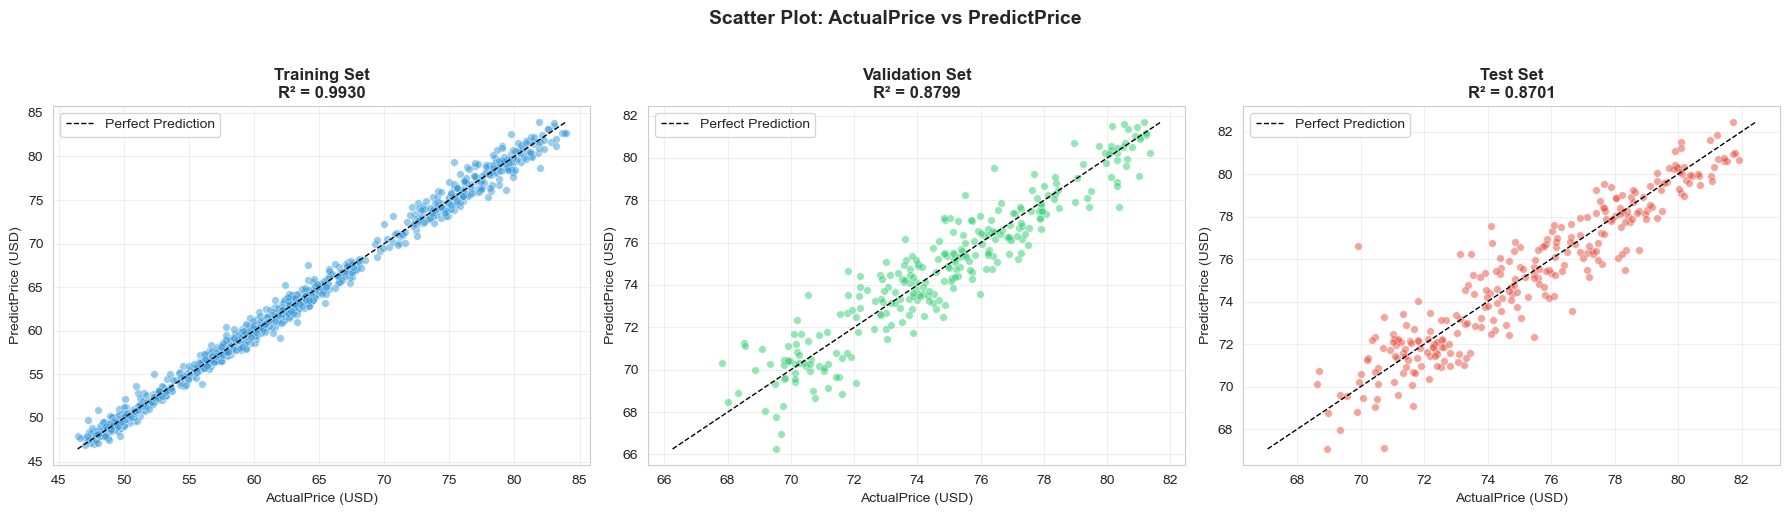

In [14]:
# กราฟ Scatter Plot: Actual vs Predicted
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sets = [
    (y_train, y_train_pred, 'Training Set', '#3498db'),
    (y_val, y_val_pred, 'Validation Set', '#2ecc71'),
    (y_test, y_test_pred, 'Test Set', '#e74c3c')
]

for ax, (y_true, y_pred, title, color) in zip(axes, sets):
    ax.scatter(y_true, y_pred, alpha=0.5, color=color, edgecolors='white', linewidth=0.5, s=30)
    
    # เส้น Perfect Prediction
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1, label='Perfect Prediction')
    
    r2 = r2_score(y_true, y_pred)
    ax.set_title(f'{title}\nR² = {r2:.4f}', fontsize=12, fontweight='bold')
    ax.set_xlabel('ActualPrice (USD)')
    ax.set_ylabel('PredictPrice (USD)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Scatter Plot: ActualPrice vs PredictPrice', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 8. Example of prediction

In [15]:
# ใช้ข้อมูลล่าสุดเพื่อทำนายราคาวันถัดไป
latest_data = data.iloc[-1:][feature_columns]
latest_data_scaled = scaler.transform(latest_data)

next_day_prediction = model.predict(latest_data_scaled)[0]
latest_date = data['date'].iloc[-1]
latest_price = data['close_x'].iloc[-1]

print('=' * 50)
print('การทำนายราคาน้ำมัน Brent วันถัดไป')
print('=' * 50)
print(f'\nวันที่ล่าสุดในข้อมูล: {latest_date.strftime("%Y-%m-%d")}')
print(f'ราคาปิดล่าสุด:        ${latest_price:.2f}')
print(f'\nราคาที่ทำนายวันถัดไป: ${next_day_prediction:.2f}')

change = next_day_prediction - latest_price
change_pct = (change / latest_price) * 100

if change > 0:
    print(f'เปลี่ยนแปลง: +${change:.2f} (+{change_pct:.2f}%)')
else:
    print(f'เปลี่ยนแปลง: ${change:.2f} ({change_pct:.2f}%)')

การทำนายราคาน้ำมัน Brent วันถัดไป

วันที่ล่าสุดในข้อมูล: 2025-04-03
ราคาปิดล่าสุด:        $69.91

ราคาที่ทำนายวันถัดไป: $70.29
เปลี่ยนแปลง: +$0.38 (+0.54%)


## 9. Summary

In [16]:
print('=' * 50)
print('FINAL RESULTS SUMMARY')
print('=' * 50)
print(f'  MSE:  ${test_metrics["MSE"]:.4f}')
print(f'  RMSE: ${test_metrics["RMSE"]:.4f}')
print(f'  MAE:  ${test_metrics["MAE"]:.4f}')
print(f'  R²:   {test_metrics["R2"]:.4f}')
print('\n' + '=' * 50)


FINAL RESULTS SUMMARY
  MSE:  $1.4529
  RMSE: $1.2054
  MAE:  $0.9299
  R²:   0.8701



## 10. Model Performance Comparison Charts

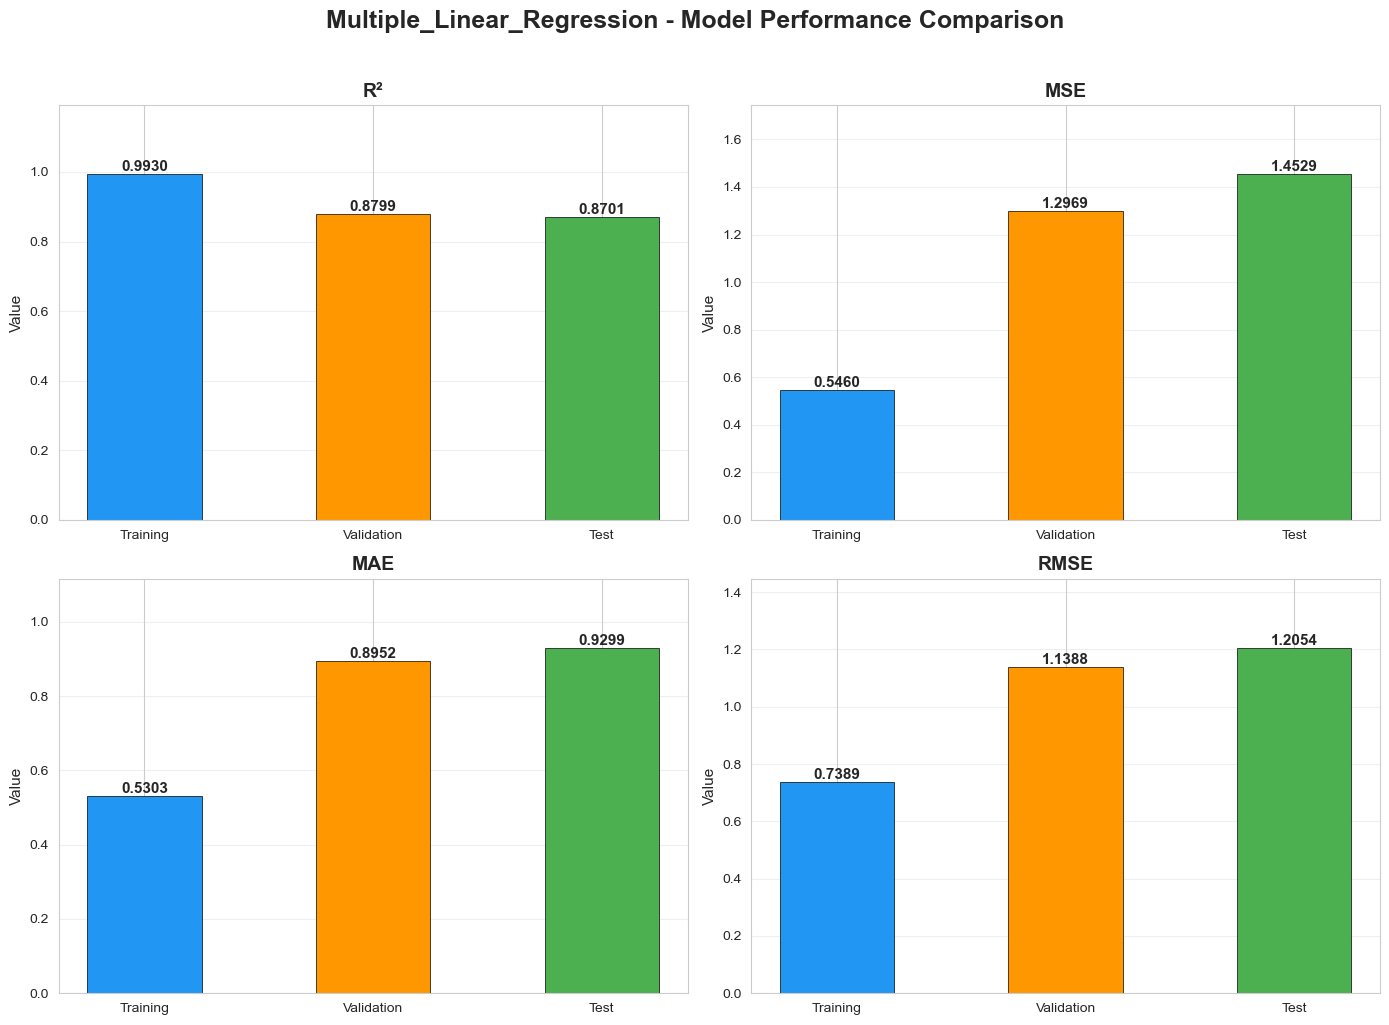

In [17]:
metrics_names = ['R²', 'MSE', 'MAE', 'RMSE']
metrics_keys = ['R2', 'MSE', 'MAE', 'RMSE']

train_values = [train_metrics[k] for k in metrics_keys]
val_values = [val_metrics[k] for k in metrics_keys]
test_values = [test_metrics[k] for k in metrics_keys]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Multiple_Linear_Regression - Model Performance Comparison', fontsize=18, fontweight='bold', y=1.02)

colors = ['#2196F3', '#FF9800', '#4CAF50']
labels = ['Training', 'Validation', 'Test']

for idx, (ax, name, key) in enumerate(zip(axes.flat, metrics_names, metrics_keys)):
    values = [train_metrics[key], val_metrics[key], test_metrics[key]]
    bars = ax.bar(labels, values, color=colors, edgecolor='black', linewidth=0.5, width=0.5)

    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_title(name, fontsize=14, fontweight='bold')
    ax.set_ylabel('Value', fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, max(values) * 1.2)

plt.tight_layout()
plt.show()